In [5]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np


# Section 1: Generate VL2 topology

def generate_vl2_topology(spine_switches=10, leaf_switches=20, servers_per_leaf=300):
    """
    Generates VL2 topology graph.
    - spine_switches: number of spine/core switches
    - leaf_switches: number of leaf switches
    - servers_per_leaf: number of servers per leaf switch
    """
    G = nx.Graph()
    spine_nodes = ["spine{}".format(i) for i in range(spine_switches)]
    leaf_nodes = ["leaf{}".format(i) for i in range(leaf_switches)]

    # Add spine nodes
    for spine in spine_nodes:
        G.add_node(spine, layer="spine")

    # Add leaf nodes and connect to spine with capacity 10
    for leaf in leaf_nodes:
        G.add_node(leaf, layer="leaf")
        for spine in spine_nodes:
            G.add_edge(leaf, spine, capacity=10)

    # Add servers and connect to leaf with capacity 1
    server_nodes = []
    for leaf in leaf_nodes:
        for s in range(servers_per_leaf):
            server = f"{leaf}-srv{s}"
            G.add_node(server, layer="server")
            G.add_edge(leaf, server, capacity=1)
            server_nodes.append(server)

    print(f"Topology: {len(spine_nodes)} spines, {len(leaf_nodes)} leafs, {len(server_nodes)} servers.")
    return G, spine_nodes, leaf_nodes, server_nodes

In [6]:

# Section 2: Routing schemes

def deterministic_route(G, src, dst):
    """
    Shortest path routing using Dijkstra's algorithm (no weights)
    """
    return nx.shortest_path(G, source=src, target=dst)

def valiant_load_balancing_route(G, src, dst, leaf_nodes):
    """
    Route via random intermediate leaf node to balance load:
    src -> intermediate leaf -> dst
    """
    src_leaf = src.split("-")[0]
    dst_leaf = dst.split("-")[0]
    candidates = [leaf for leaf in leaf_nodes if leaf != src_leaf and leaf != dst_leaf]
    intermediate = random.choice(candidates)
    path1 = nx.shortest_path(G, source=src, target=intermediate)
    path2 = nx.shortest_path(G, source=intermediate, target=dst)
    # Combine paths excluding duplicate node
    return path1 + path2[1:]

In [ ]:

# Section 3: Traffic generation with elephant & mice flows

def generate_flows(server_nodes, num_flows=200, elephant_ratio=0.1):
    """
    Generate flows with varied sizes:
    - elephant_ratio: fraction of flows with large size (elephants)
    Each flow is (src, dst, size)
    """
    flows = []
    for _ in range(num_flows):
        src = random.choice(server_nodes)
        dst = random.choice(server_nodes)
        while dst == src:
            dst = random.choice(server_nodes)
        # Assign flow size: 10 units for elephant, 1 unit for mice
        size = 10 if random.random() < elephant_ratio else 1
        flows.append((src, dst, size))
    print(f"Generated {num_flows} flows, with {int(elephant_ratio*num_flows)} elephant flows.")
    return flows


In [8]:

# Section 4: Active capacity aware flow simulation

def simulate_flows(G, flows, leaf_nodes, routing_scheme="deterministic", retry_on_drop=False, max_retries=3):
    """
    Simulates flow routing considering capacity constraints actively:
    - Drops flow if any link exceeds capacity when adding flow size
    - Option to retry with alternative intermediate nodes for VLB
    """
    link_load = {edge: 0 for edge in G.edges()}
    dropped_flows = 0

    for (src, dst, size) in flows:
        retries = 0
        while retries <= max_retries:
            # Compute path
            if routing_scheme == "deterministic":
                path = deterministic_route(G, src, dst)
            elif routing_scheme == "vlb":
                path = None
                if retry_on_drop:
                    # Try multiple attempts with different intermediate leaves
                    src_leaf = src.split("-")[0]
                    dst_leaf = dst.split("-")[0]
                    candidates = [leaf for leaf in leaf_nodes if leaf != src_leaf and leaf != dst_leaf]
                    if not candidates:
                        path = deterministic_route(G, src, dst)
                    else:
                        intermediate = random.choice(candidates)
                        path1 = nx.shortest_path(G, source=src, target=intermediate)
                        path2 = nx.shortest_path(G, source=intermediate, target=dst)
                        path = path1 + path2[1:]
                else:
                    path = valiant_load_balancing_route(G, src, dst, leaf_nodes)
            else:
                raise ValueError("Invalid routing scheme")

            # Check if capacity available on path
            capacity_ok = True
            for i in range(len(path)-1):
                edge = (path[i], path[i+1])
                if edge not in link_load:
                    edge = (path[i+1], path[i])
                if link_load[edge] + size > G.edges[edge]['capacity']:
                    capacity_ok = False
                    break

            if capacity_ok:
                # Add load
                for i in range(len(path)-1):
                    edge = (path[i], path[i+1])
                    if edge not in link_load:
                        edge = (path[i+1], path[i])
                    link_load[edge] += size
                break
            else:
                retries += 1
                if retries > max_retries:
                    dropped_flows += 1
                    break

    print(f"Simulated {len(flows)} flows with routing '{routing_scheme}' with {dropped_flows} dropped flows.")
    return link_load, dropped_flows


In [9]:

# Section 5: Metrics calculation including fairness and congestion

def calculate_metrics(link_load, G):
    """
    Calculate max load, average load, Jain's fairness, and congestion links.
    """
    loads = list(link_load.values())
    max_load = max(loads)
    avg_load = sum(loads) / len(loads)

    # Jain's fairness index
    numerator = (sum(loads))**2
    denominator = len(loads)*sum([l**2 for l in loads])
    fairness = numerator/denominator if denominator != 0 else 1.0

    # Congestion: links exceeding capacity
    congested_links = [edge for edge, load in link_load.items() if load > G.edges[edge]['capacity']]
    congestion_ratio = len(congested_links) / len(link_load)

    print(f"Max load: {max_load}")
    print(f"Avg load: {avg_load:.2f}")
    print(f"Jain's Fairness: {fairness:.3f}")
    print(f"Congested links: {len(congested_links)} ({congestion_ratio*100:.2f}%)")

    return max_load, avg_load, fairness, len(congested_links), congestion_ratio

In [10]:

# Section 6: Results visualization

def plot_link_load_histogram(link_load, title):
    """
    Plot histogram of the link load distribution.
    """
    loads = list(link_load.values())
    plt.figure(figsize=(9,5))
    plt.hist(loads, bins=range(max(loads)+2), alpha=0.7, color='blue', edgecolor='black')
    plt.title(title)
    plt.xlabel("Link Load (flow units count)")
    plt.ylabel("Number of Links")
    plt.grid(True)
    plt.show()


=== Simulation scale: Spines=2, Leafs=4, Servers/Leaf=4, Flows=100 ===
Topology: 2 spines, 4 leafs, 16 servers.
Generated 100 flows, with 15 elephant flows.
Simulated 100 flows with routing 'deterministic' with 92 dropped flows.

Deterministic routing metrics:
Max load: 4
Avg load: 1.25
Jain's Fairness: 0.551
Congested links: 0 (0.00%)


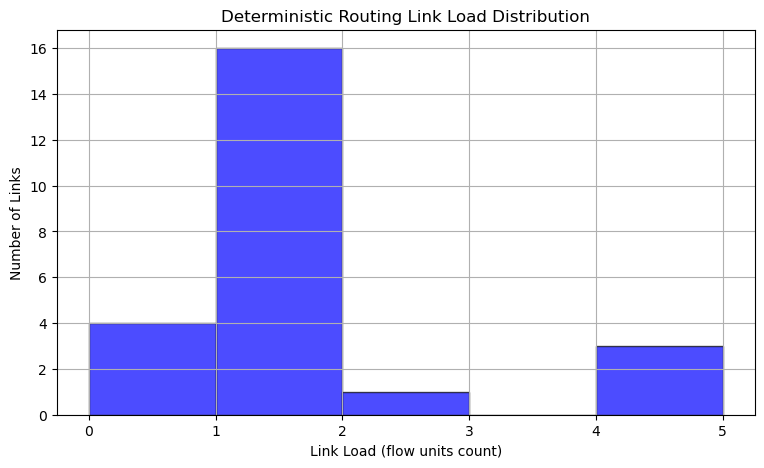

Simulated 100 flows with routing 'vlb' with 93 dropped flows.

Valiant Load Balancing routing metrics:
Max load: 10
Avg load: 1.75
Jain's Fairness: 0.320
Congested links: 0 (0.00%)


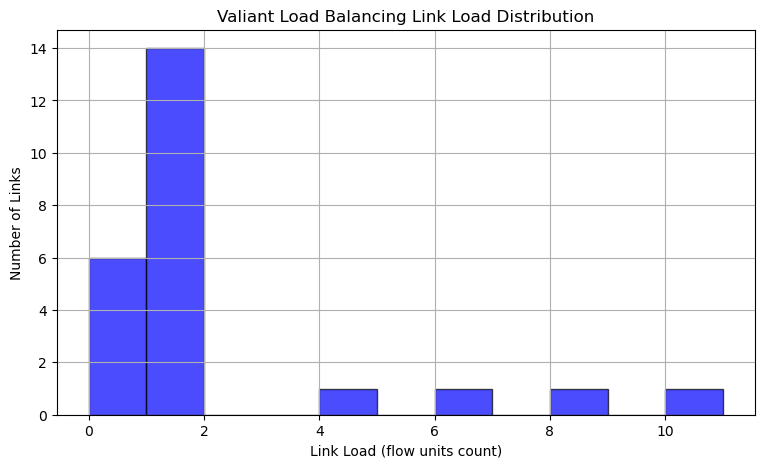


Comparison summary:
Deterministic dropped flows: 92, VLB dropped flows: 93
Deterministic max load: 4, VLB max load: 10
Deterministic avg load: 1.25, VLB avg load: 1.75
Deterministic fairness: 0.551, VLB fairness: 0.320
Deterministic congested links: 0, VLB congested links: 0
Congestion ratio det: 0.00%, vlb: 0.00%

=== Simulation scale: Spines=4, Leafs=8, Servers/Leaf=4, Flows=300 ===
Topology: 4 spines, 8 leafs, 32 servers.
Generated 300 flows, with 45 elephant flows.
Simulated 300 flows with routing 'deterministic' with 285 dropped flows.

Deterministic routing metrics:
Max load: 4
Avg load: 0.88
Jain's Fairness: 0.408
Congested links: 0 (0.00%)


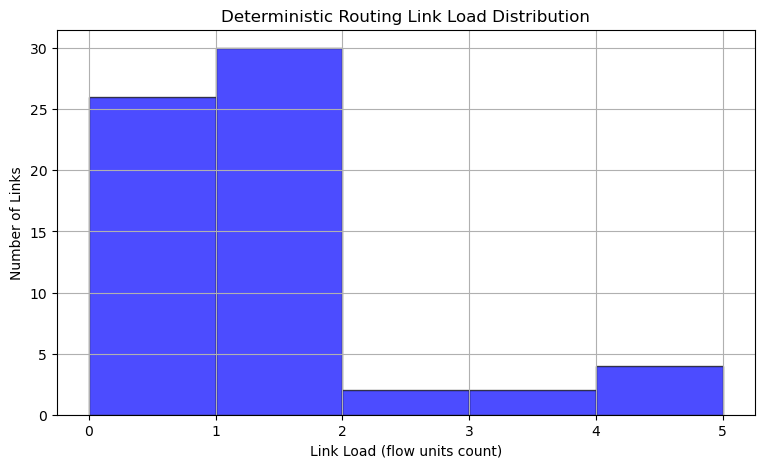

Simulated 300 flows with routing 'vlb' with 286 dropped flows.

Valiant Load Balancing routing metrics:
Max load: 11
Avg load: 1.31
Jain's Fairness: 0.246
Congested links: 1 (1.56%)


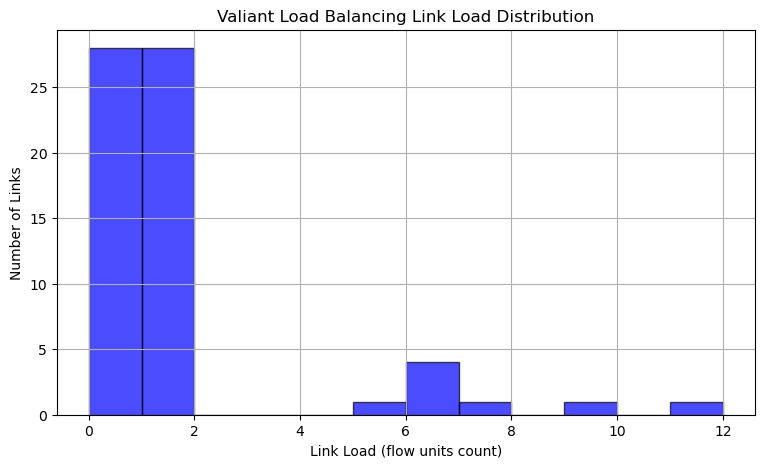


Comparison summary:
Deterministic dropped flows: 285, VLB dropped flows: 286
Deterministic max load: 4, VLB max load: 11
Deterministic avg load: 0.88, VLB avg load: 1.31
Deterministic fairness: 0.408, VLB fairness: 0.246
Deterministic congested links: 0, VLB congested links: 1
Congestion ratio det: 0.00%, vlb: 1.56%

=== Simulation scale: Spines=6, Leafs=12, Servers/Leaf=6, Flows=600 ===
Topology: 6 spines, 12 leafs, 72 servers.
Generated 600 flows, with 90 elephant flows.
Simulated 600 flows with routing 'deterministic' with 567 dropped flows.

Deterministic routing metrics:
Max load: 6
Avg load: 0.90
Jain's Fairness: 0.283
Congested links: 0 (0.00%)


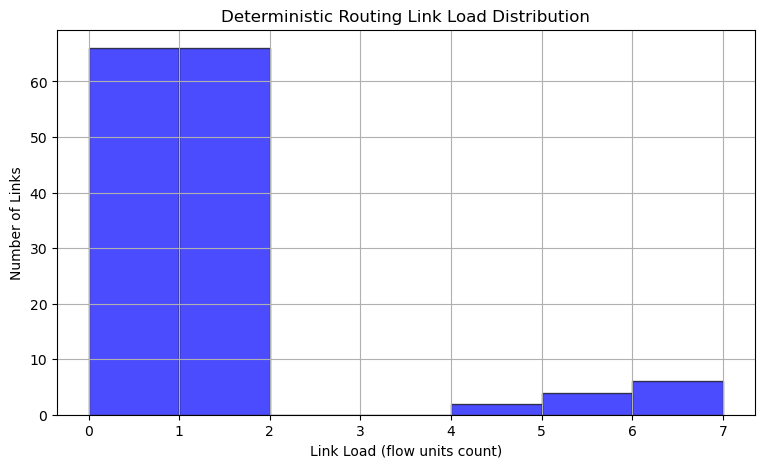

Simulated 600 flows with routing 'vlb' with 573 dropped flows.

Valiant Load Balancing routing metrics:
Max load: 10
Avg load: 1.12
Jain's Fairness: 0.171
Congested links: 0 (0.00%)


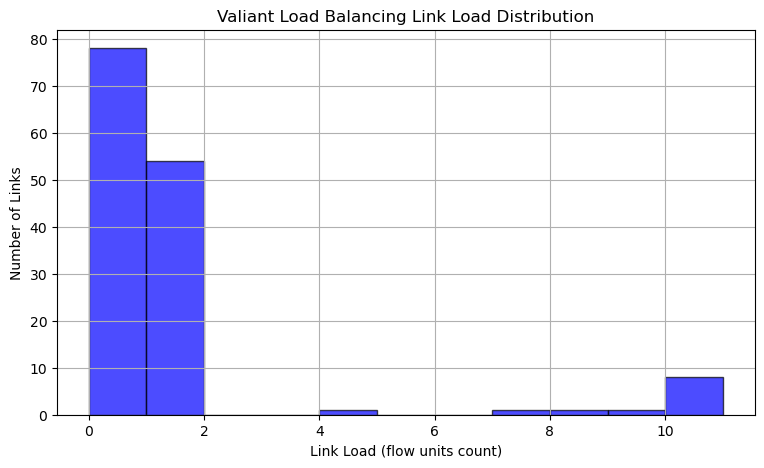


Comparison summary:
Deterministic dropped flows: 567, VLB dropped flows: 573
Deterministic max load: 6, VLB max load: 10
Deterministic avg load: 0.90, VLB avg load: 1.12
Deterministic fairness: 0.283, VLB fairness: 0.171
Deterministic congested links: 0, VLB congested links: 0
Congestion ratio det: 0.00%, vlb: 0.00%

=== Simulation scale: Spines=6, Leafs=12, Servers/Leaf=6, Flows=600 ===
Topology: 6 spines, 12 leafs, 72 servers.
Generated 600 flows, with 90 elephant flows.
Simulated 600 flows with routing 'deterministic' with 566 dropped flows.

Deterministic routing metrics:
Max load: 6
Avg load: 0.92
Jain's Fairness: 0.289
Congested links: 0 (0.00%)


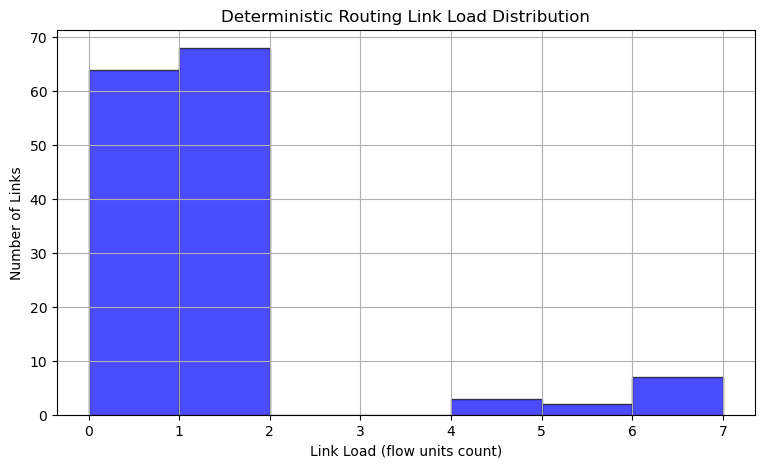

Simulated 600 flows with routing 'vlb' with 572 dropped flows.

Valiant Load Balancing routing metrics:
Max load: 11
Avg load: 1.17
Jain's Fairness: 0.172
Congested links: 3 (2.08%)


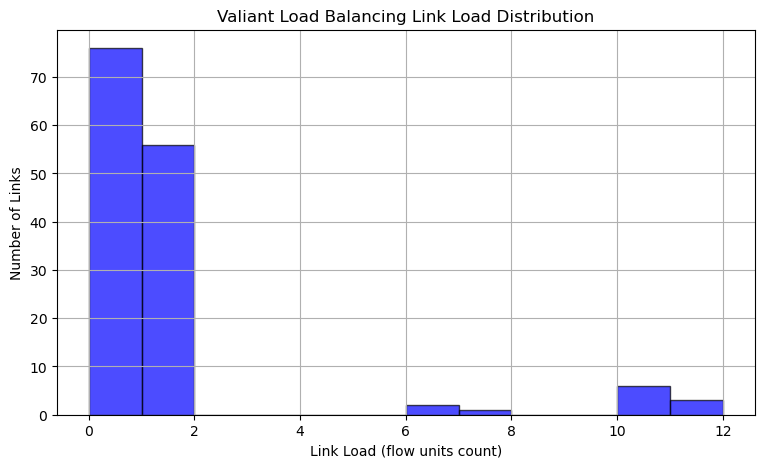


Comparison summary:
Deterministic dropped flows: 566, VLB dropped flows: 572
Deterministic max load: 6, VLB max load: 11
Deterministic avg load: 0.92, VLB avg load: 1.17
Deterministic fairness: 0.289, VLB fairness: 0.172
Deterministic congested links: 0, VLB congested links: 3
Congestion ratio det: 0.00%, vlb: 2.08%

=== Simulation scale: Spines=10, Leafs=20, Servers/Leaf=6, Flows=800 ===
Topology: 10 spines, 20 leafs, 120 servers.
Generated 800 flows, with 120 elephant flows.
Simulated 800 flows with routing 'deterministic' with 743 dropped flows.

Deterministic routing metrics:
Max load: 6
Avg load: 0.71
Jain's Fairness: 0.211
Congested links: 0 (0.00%)


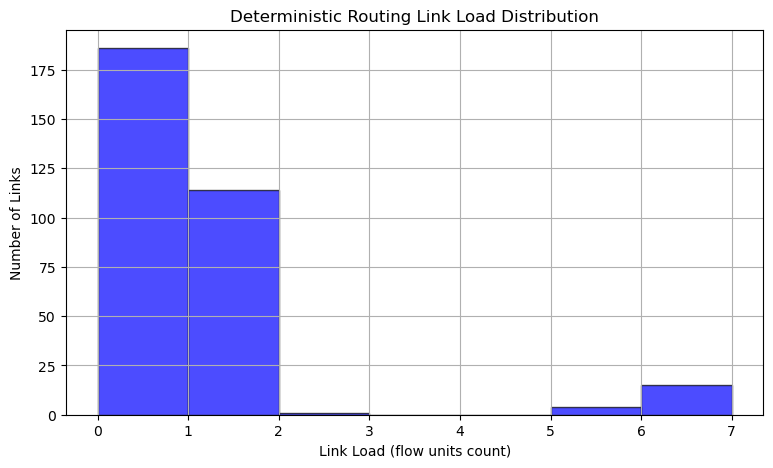

Simulated 800 flows with routing 'vlb' with 751 dropped flows.

Valiant Load Balancing routing metrics:
Max load: 11
Avg load: 0.92
Jain's Fairness: 0.133
Congested links: 4 (1.25%)


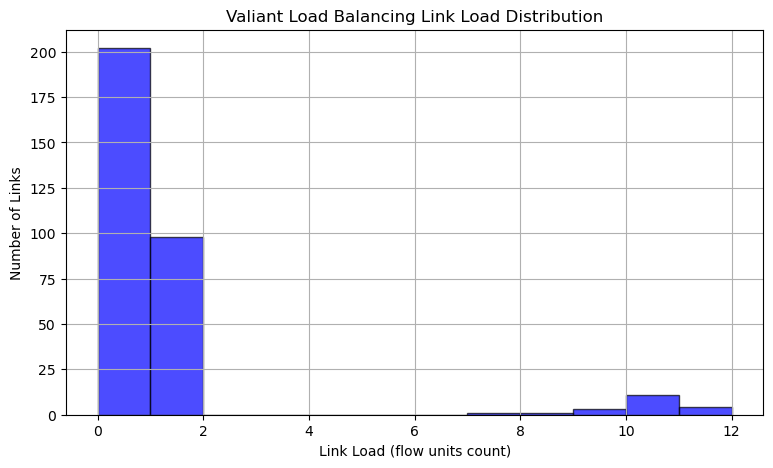


Comparison summary:
Deterministic dropped flows: 743, VLB dropped flows: 751
Deterministic max load: 6, VLB max load: 11
Deterministic avg load: 0.71, VLB avg load: 0.92
Deterministic fairness: 0.211, VLB fairness: 0.133
Deterministic congested links: 0, VLB congested links: 4
Congestion ratio det: 0.00%, vlb: 1.25%


In [14]:

# Section 7: Main execution with multiple scales and options

if __name__ == "__main__":
    # Define multiple network scales and flow volumes for testing scalability
    network_scales = [
        {"spine": 2, "leaf": 4, "servers": 4, "flows": 100},
        {"spine": 4, "leaf": 8, "servers": 4, "flows": 300},
        {"spine": 6, "leaf": 12, "servers": 6, "flows": 600},
        {"spine": 6, "leaf": 12, "servers": 6, "flows": 600},
        {"spine": 10, "leaf": 20, "servers": 6, "flows": 800},
    ]

    for scale in network_scales:
        print(f"\n=== Simulation scale: Spines={scale['spine']}, Leafs={scale['leaf']}, Servers/Leaf={scale['servers']}, Flows={scale['flows']} ===")

        G, spine_nodes, leaf_nodes, server_nodes = generate_vl2_topology(
            spine_switches=scale["spine"],
            leaf_switches=scale["leaf"],
            servers_per_leaf=scale["servers"]
        )
        flows = generate_flows(server_nodes, num_flows=scale["flows"], elephant_ratio=0.15)

        # Deterministic routing simulation
        det_load, det_dropped = simulate_flows(G, flows, leaf_nodes, routing_scheme="deterministic")
        print("\nDeterministic routing metrics:")
        det_metrics = calculate_metrics(det_load, G)
        plot_link_load_histogram(det_load, "Deterministic Routing Link Load Distribution")

        # VLB routing simulation with retry on drop enabled
        vlb_load, vlb_dropped = simulate_flows(G, flows, leaf_nodes, routing_scheme="vlb", retry_on_drop=True)
        print("\nValiant Load Balancing routing metrics:")
        vlb_metrics = calculate_metrics(vlb_load, G)
        plot_link_load_histogram(vlb_load, "Valiant Load Balancing Link Load Distribution")

        # Summary comparison
        print("\nComparison summary:")
        print(f"Deterministic dropped flows: {det_dropped}, VLB dropped flows: {vlb_dropped}")
        print(f"Deterministic max load: {det_metrics[0]}, VLB max load: {vlb_metrics[0]}")
        print(f"Deterministic avg load: {det_metrics[1]:.2f}, VLB avg load: {vlb_metrics[1]:.2f}")
        print(f"Deterministic fairness: {det_metrics[2]:.3f}, VLB fairness: {vlb_metrics[2]:.3f}")
        print(f"Deterministic congested links: {det_metrics[3]}, VLB congested links: {vlb_metrics[3]}")
        print(f"Congestion ratio det: {det_metrics[4]:.2%}, vlb: {vlb_metrics[4]:.2%}")
        print("="*60)
